# Answering Business Questions 

This project uses the Chinook database, which is comprise of relational SQL tables containing information about employees, customers, purchases and music.  

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Creating a function to quickly run an SQ
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
# A function to run SQL quaries that don't return tables
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
# A function to return a list of all tables and views in our databases
def show_tables():
    q = "SELECT name,type FROM sqlite_master WHERE type IN ('table', 'view');"
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Music by Genre

In [5]:
# a query that returns each genre, with the number of tracks sold in absolute numbers and in percentages.
q = "WITH song_sales AS(SELECT g.name genre, t.track_id, il.quantity FROM genre g LEFT JOIN track t ON g.genre_id = t.genre_id LEFT JOIN invoice_line il ON il.track_id = t.track_id) SELECT genre, SUM(quantity) purchased_songs, CAST(SUM(quantity) as FLOAT)/ (SELECT SUM(quantity) FROM song_sales) * 100 per_sales FROM song_sales GROUP BY 1 ORDER BY 3 DESC"

genre_sales = run_query(q)

In [6]:
# Setting the index 
genre_sales.set_index('genre', drop=True, inplace=True)

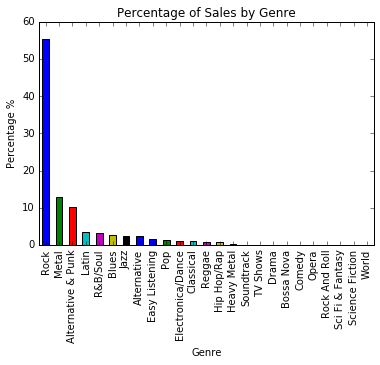

In [7]:
# Bar plot of the percentage of sales by genre
genre_sales['per_sales'].plot.bar()
plt.title("Percentage of Sales by Genre")
plt.xlabel("Genre")
plt.ylabel("Percentage %")
plt.show()

## Music by Genre: Observations

Based on the data, the highest selling tracks are in the Rock, Metal and Alternative Genre.  The user base does not seem to listen to any of the more eclectic genres.  

## Sales Agent Performance

In [8]:
# A query that finds the total dollar amount of sales assigned to each sales support agent within the company with extra attributes for employees that might be relevant to the analysis
q = "SELECT e.first_name || ' ' || e.last_name employee_name, e.employee_id, SUM(i.total) customer_purchase, e.hire_date, e.birthdate, e.postal_code FROM employee e LEFT JOIN customer c ON e.employee_id = c.support_rep_id LEFT JOIN invoice i ON c.customer_id = i.customer_id WHERE e.title = \"Sales Support Agent\" GROUP BY 1 ORDER BY 3"
# Saving the query
sales_agents = run_query(q)

print("Detailed summary of sales support agents:")
sales_agents

Detailed summary of sales support agents:


,employee_name,employee_id,customer_purchase,hire_date,birthdate,postal_code
0,Steve Johnson,5,1393.92,2017-10-17 00:00:00,1965-03-03 00:00:00,T3B 1Y7
1,Margaret Park,4,1584.00,2017-05-03 00:00:00,1947-09-19 00:00:00,T2P 5G3
2,Jane Peacock,3,1731.51,2017-04-01 00:00:00,1973-08-29 00:00:00,T2P 5M5


In [9]:
# Resetting the index to the employee names 
sales_agents.set_index('employee_name', drop=True, inplace=True)

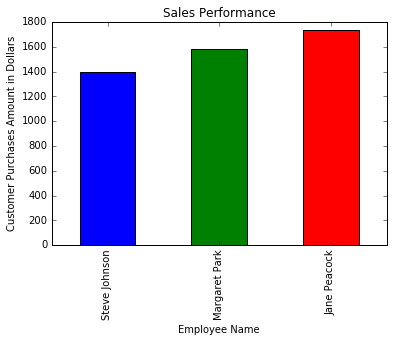

In [10]:
sales_agents['customer_purchase'].plot.bar()
plt.ylabel("Customer Purchases Amount in Dollars")
plt.xlabel("Employee Name")
plt.title("Sales Performance")
plt.show()

## Performancec: Observations

There wasn't substantial differences in the values of customer purchase between Sales Support Agents.   The highest performing Agent also had the earliest start date, which probably allowed for a head start.  

## Sales Data by Country

Analyze the sales data for customers from each different country. 

- total number of customers
- total value of sales
- average value of sales per customer
- average order value


In [11]:
q = ''' 
WITH cust_sum AS (
SELECT customer_id,
    SUM(total) tot_purchased,
    AVG(total) avg_total
FROM invoice 
GROUP BY 1
ORDER BY 2)

SELECT 
    country,
    SUM(cust_purchases) total_customers,
    SUM(tot_purchased) total_sales,
    ROUND(CAST(SUM(tot_purchased) AS float) / SUM(cust_purchases), 2) avg_customer,
    ROUND(avg_total, 2) avg_order
FROM (
SELECT 
    CASE
        WHEN COUNT(cs.customer_id) = 1 THEN 'Other'
        ELSE c.country END country,
    COUNT(cs.customer_id) cust_purchases,
    SUM(cs.tot_purchased) tot_purchased,
    cs.avg_total
FROM cust_sum cs
LEFT JOIN customer c ON cs.customer_id = c.customer_id
GROUP BY country
ORDER BY 2 DESC)
GROUP BY country
ORDER BY CASE 
    WHEN country = 'Other' THEN 1
    ELSE 0 END, total_sales DESC
'''
    
run_query(q)

,country,total_customers,total_sales,avg_customer,avg_order
0,USA,13,1040.49,80.04,8.17
1,Canada,8,535.59,66.95,11.11
2,Brazil,5,427.68,85.54,8.38
3,France,5,389.07,77.81,9.09
4,Germany,4,334.62,83.66,9.41
5,Czech Republic,2,273.24,136.62,8.03
6,United Kingdom,3,245.52,81.84,8.91
7,Portugal,2,185.13,92.56,7.92
8,India,2,183.15,91.57,8.61
9,Other,15,1094.94,73.00,7.52


In [12]:
sales_by_country = run_query(q)

## Visualization

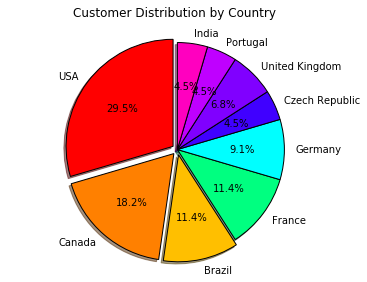

In [13]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
countries = sales_by_country['country'].tolist()
labels = countries[:9]

customers_by_country = sales_by_country['total_customers'].tolist()
sizes = customers_by_country[:9]

# only "explode" the 1-3 slice 
explode = (0.05, 0.05, 0.05, 0, 0, 0, 0, 0, 0)  

color = ['#ff0000', '#ff8000', '#ffbf00', '#00ff80', '#00ffff', '#4000ff', '#8000ff', '#bf00ff', '#ff00bf', '#ff0080']

# Generate the figure
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors = color[:9], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Customer Distribution by Country", y=1.08)
plt.show()

In [14]:
# Setting the index to allow for easier bar graphs
indexed_sales = sales_by_country.set_index('country', drop=True)

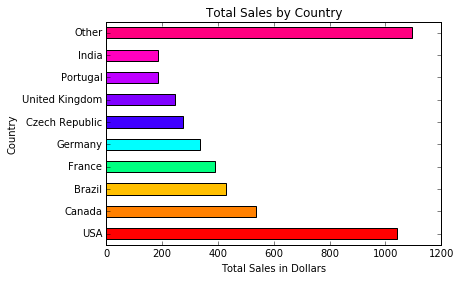

In [15]:
# Creating horizontal bar plots following the previously established color scheme
indexed_sales['total_sales'].plot.barh(color = color)

plt.ylabel("Country")
plt.xlabel("Total Sales in Dollars")
plt.title("Total Sales by Country")

plt.show()

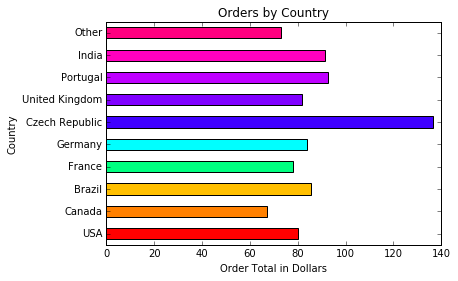

In [16]:
indexed_sales['avg_customer'].plot.barh(color = color)

plt.ylabel("Country")
plt.xlabel("Order Total in Dollars")
plt.title("Orders by Country")

plt.show()

## Country: Observations

The USA has the largest number of customers, followed by Canada.  However, the largest orders are completed by people in the Czech Republic.  The USA produce the largest total sales.

## Album Purchases

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual track

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

In [36]:
q = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(q)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


## Album Purchases: Observations

With only 18% of customers purchasing hte full album it is probably safe to stop purchasing full albums and only pick popular songs off of albums.